In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeProvider, FakeManila, FakeToronto, FakeJakartaV2
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter
import qiskit.quantum_info as qi
import qiskit
from qiskit.visualization import plot_histogram

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import scipy
import os
import sys
import itertools
from numpy.random import Generator, PCG64
from datetime import date
import pathlib
import inspect
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
plot_path = f'{module_path}/plots'
sys.path.insert(0, os.path.abspath('../src/'))

from feedforward import QExtremeLearningMachine
from rewinding import QRewindingRC, QRewindingStatevectorRC
from data import DataSource
from noisemodel import thermal_model

from IPython.display import display


In [2]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector, DensityMatrix

# Noisy density matrix simulations

Since partial measurements / resets take ages in qiskit, we use statevector simulations in QRewindingStatevectorRC.
If we want to simulate noise, we need to move to density matrix simulations.

Here we test if DM simulations run feasably fast.

- sv_evolve_noiseless
- dm_evolve_noiseless
- dm_set_get_noiseless
- dm_set_get_toronto
- dm_set_get_custom

Insights

- noisy DM takes ~ 10 times longer than noiseless SV 
- 2-5 qubits runtime is roughly constant
- above 6 qubits runtime explodes
- custom noisemodel is about 25-50% faster than device noisemodel

## Individual Experiments

Scroll down to combined experiments

In [3]:
from circuits import ising_circuit

shots = 2**13
nmeas = 2
qmeas = [*range(nmeas)]
nqubits_list = [*range(nmeas, 10)]
navg = 20

df = pd.DataFrame()
df['nqubits'] = nqubits_list

<Axes: title={'center': 'Evolve Noiseless (measuring all qubits)'}, xlabel='nqubits', ylabel='time [s]'>

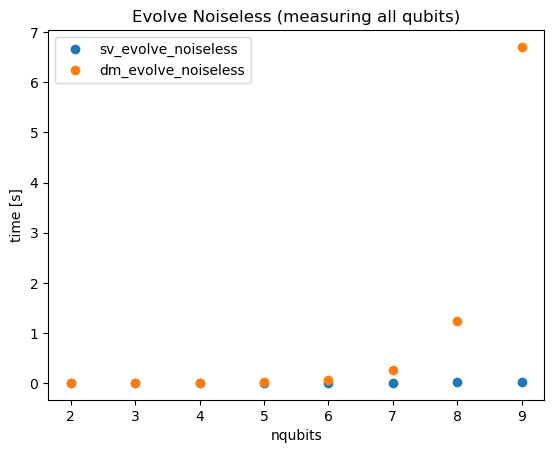

In [4]:
# What we are doing in QRewindingStatevectorRC
# evolving a SV through a QuantumCircuit

name = 'evolve_noiseless'

sv_times = np.zeros(shape=(len(nqubits_list),))
dm_times = np.zeros(shape=(len(nqubits_list),))


for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        # sv_init = qi.Statevector.from_label('0'*nqubits)
        sv_init = qi.Statevector.from_instruction(qc_ising)

        t0 = time.time()
        #
        statev = sv_init.evolve(qc_ising)
        # counts = statev.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        sv_times[cnt] += t1


        rho = qi.DensityMatrix(sv_init.data)

        t0 = time.time()
        #
        rho = rho.evolve(qc_ising)
        # counts_rho = rho.sample_counts(shots=shots)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'sv_{name}'] = sv_times
df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=[f'sv_{name}', f'dm_{name}'], 
    linestyle="none", marker="o", title='Evolve Noiseless (measuring all qubits)', ylabel='time [s]')

<Axes: title={'center': 'Set Get Noiseless (measuring all qubits)'}, xlabel='nqubits', ylabel='time [s]'>

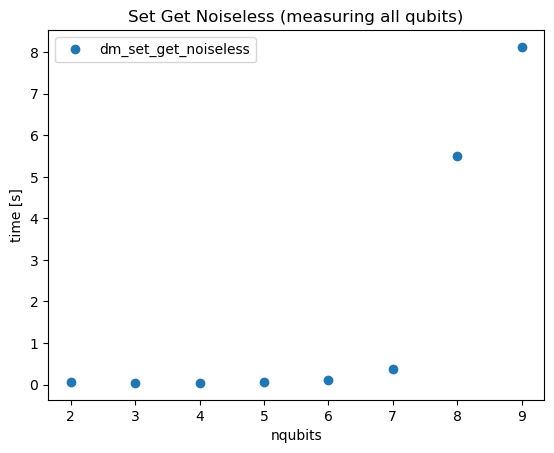

In [5]:
# the only way to get a noisy density matrix is to use qc.save_density_matrix()
# which means we need to use qc.set_density_matrix() as well
# instead of evolving.
# first we test set and get with noiseless simulation

name = 'set_get_noiseless'

aer_method = 'density_matrix'
backend = AerSimulator(method = aer_method)

dm_times = np.zeros(shape=(len(nqubits_list),))


for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        sv_init = qi.DensityMatrix.from_instruction(qc_ising)
        sv_init = qi.DensityMatrix(qc_ising)

        t0 = time.time()
        #
        circ = QuantumCircuit(nqubits)
        circ.set_density_matrix(sv_init)

        circ.append(qc_ising, qargs=[*range(nqubits)])

        circ.save_density_matrix(qubits=None, label="dm", conditional=False)

        circ = transpile(circ, backend)
        job = backend.run(circ)
        result = job.result()
        state = result.data()['dm']
        # counts = state.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'dm_{name}', 
    linestyle="none", marker="o", title='Set Get Noiseless (measuring all qubits)', ylabel='time [s]')

<Axes: title={'center': 'Set Get Toronto (measuring all qubits)'}, xlabel='nqubits', ylabel='time [s]'>

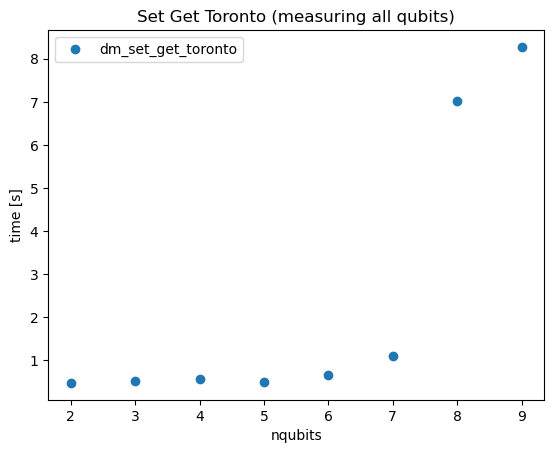

In [6]:
# test set and get with noisy simulation from device

name = 'set_get_toronto'

aer_method = 'density_matrix'
provider = FakeProvider()
backend = provider.get_backend('fake_toronto')
noise_model = NoiseModel.from_backend(backend)
backend = AerSimulator(method = aer_method, noise_model = noise_model)

dm_times = np.zeros(shape=(len(nqubits_list),))


for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        sv_init = qi.DensityMatrix.from_instruction(qc_ising)
        sv_init = qi.DensityMatrix(qc_ising)

        t0 = time.time()
        #
        circ = QuantumCircuit(nqubits)
        circ.set_density_matrix(sv_init)

        circ.append(qc_ising, qargs=[*range(nqubits)])

        circ.save_density_matrix(qubits=None, label="dm", conditional=False)

        circ = transpile(circ, backend)
        job = backend.run(circ)
        result = job.result()
        state = result.data()['dm']
        # counts = state.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'dm_{name}', 
    linestyle="none", marker="o", title='Set Get Toronto (measuring all qubits)', ylabel='time [s]')

<Axes: title={'center': 'Set Get Toronto (measuring all qubits)'}, xlabel='nqubits', ylabel='time [s]'>

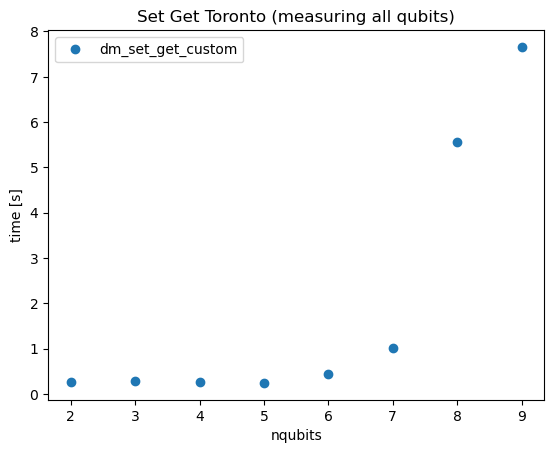

In [7]:
# test set and get with noisy simulation with simpler, custom noise model

name = 'set_get_custom'

aer_method = 'density_matrix'
noise_model = thermal_model(nqubits=nqubits)
backend = AerSimulator(method = aer_method, noise_model = noise_model)

dm_times = np.zeros(shape=(len(nqubits_list),))


for cnt, nqubits in enumerate(nqubits_list):
    for _ in range(navg):
        qc_ising = ising_circuit(nqubits=nqubits)
        qmeas = [*range(nqubits)]

        sv_init = qi.DensityMatrix.from_instruction(qc_ising)
        sv_init = qi.DensityMatrix(qc_ising)

        t0 = time.time()
        #
        circ = QuantumCircuit(nqubits)
        circ.set_density_matrix(sv_init)

        circ.append(qc_ising, qargs=[*range(nqubits)])

        circ.save_density_matrix(qubits=None, label="dm", conditional=False)

        circ = transpile(circ, backend)
        job = backend.run(circ)
        result = job.result()
        state = result.data()['dm']
        # counts = state.sample_counts(shots=shots, qargs=qmeas)
        #
        t1 = time.time() - t0
        dm_times[cnt] += t1

df[f'dm_{name}'] = dm_times

df.plot(
    x='nqubits', 
    y=f'dm_{name}', 
    linestyle="none", marker="o", title='Set Get Toronto (measuring all qubits)', ylabel='time [s]')

## Experiments combined

<Axes: title={'center': 'Measuring all qubits'}, xlabel='nqubits', ylabel='time [s]'>

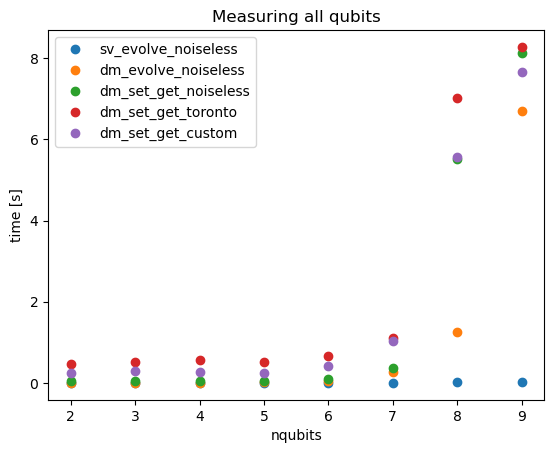

In [8]:
df.plot(
    x='nqubits', 
    y=[c for c in df.columns.to_list() if c not in ['nqubits']],
    linestyle="none", marker="o", 
    title='Measuring all qubits', ylabel='time [s]',
)

<Axes: title={'center': 'Measuring all qubits'}, xlabel='nqubits', ylabel='time [s]'>

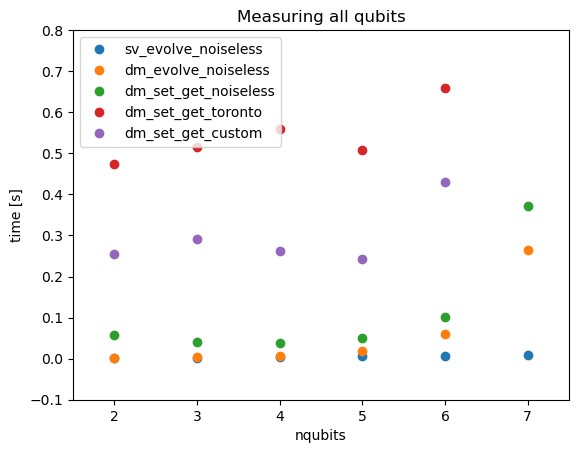

In [21]:
df.plot(
    x='nqubits', 
    y=[c for c in df.columns.to_list() if c not in ['nqubits']],
    linestyle="none", marker="o", 
    title='Measuring all qubits', ylabel='time [s]',
    xlim=[1.5, 7.5],
    ylim=[-.1, .8],
)

<Axes: title={'center': 'Measuring all qubits'}, xlabel='nqubits', ylabel='time [s]'>

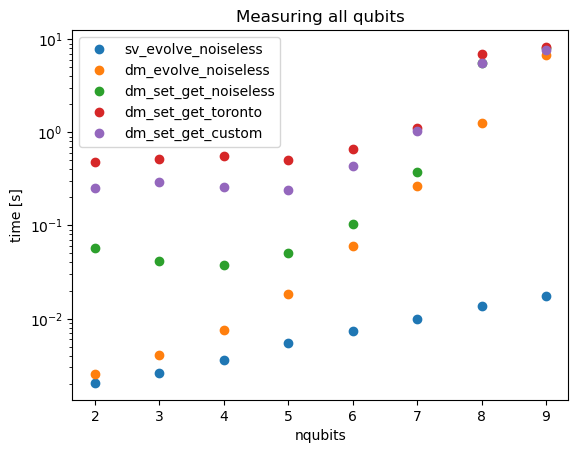

In [9]:
df.plot(
    x='nqubits', 
    y=[c for c in df.columns.to_list() if c not in ['nqubits']],
    linestyle="none", marker="o", 
    title='Measuring all qubits', ylabel='time [s]',
    logy=True,
)

# example

In [10]:


provider = FakeProvider()
backend = provider.get_backend('fake_manila')
noise_model = NoiseModel.from_backend(backend)

noisy_simulator = AerSimulator(method = 'density_matrix', noise_model = noise_model)

circ = QuantumCircuit(5, 2)
circ.h(2)
circ.cx(2, 1)
circ.cx(1, 0)
circ.cx(2, 3)
circ.cx(3, 4)
circ.barrier()
circ.measure(0, 0)
circ.measure(1, 1)
circ.save_density_matrix(qubits=None, label="dm", conditional=True)
circ.draw('mpl')

job = noisy_simulator.run(circ)
result = job.result()

# Get statevector for each measurement:
for meas, state in result.data()['dm'].items():
    display(meas)
    display(state.draw('latex'))

'0x1'

<IPython.core.display.Latex object>

'0x2'

<IPython.core.display.Latex object>

'0x3'

<IPython.core.display.Latex object>

'0x0'

<IPython.core.display.Latex object>

# Get DM

In [11]:
# Noisy DM

provider = FakeProvider()
backend = provider.get_backend('fake_manila')
noise_model = NoiseModel.from_backend(backend)

noisy_simulator = AerSimulator(method = 'density_matrix', noise_model = noise_model)

circ = QuantumCircuit(5, 2)
circ.h(2)
circ.cx(2, 1)
circ.cx(1, 0)
circ.cx(2, 3)
circ.cx(3, 4)
circ.barrier()
circ.save_density_matrix(qubits=None, label="dm", conditional=False)
circ.draw('mpl')

job = noisy_simulator.run(circ)
result = job.result()

state = result.data()['dm']

In [12]:
# Noiseless SV

provider = FakeProvider()
backend = provider.get_backend('fake_manila')
noise_model = NoiseModel.from_backend(backend)
noisy_simulator = AerSimulator(method = 'statevector')

circ = QuantumCircuit(5, 2)
circ.h(2)
circ.cx(2, 1)
circ.cx(1, 0)
circ.cx(2, 3)
circ.cx(3, 4)
circ.barrier()
circ.save_density_matrix(qubits=None, label="dm", conditional=False)
circ.draw('mpl')

job = noisy_simulator.run(circ)
result = job.result()

# Get statevector for each measurement:
state = result.data()['dm']

# Set and get DM

In [13]:
nqubits = 5

In [14]:

noisy_simulator = AerSimulator(method = 'density_matrix')

sv = Statevector.from_label('+'*nqubits)
sv = DensityMatrix(sv)

# Set initial state to generated statevector
circ = QuantumCircuit(nqubits)
circ.set_density_matrix(sv)

circ.h(2)
circ.cx(2, 1)
circ.cx(1, 0)
circ.cx(2, 3)
circ.cx(3, 4)

circ.save_density_matrix(qubits=None, label="dm", conditional=False)

job = noisy_simulator.run(circ)
result = job.result()
state = result.data()['dm']

state

DensityMatrix([[ 6.2500000e-02+0.00000000e+00j,
                 6.2500000e-02+0.00000000e+00j,
                 6.2500000e-02+0.00000000e+00j, ...,
                -6.9388939e-18-3.82702125e-18j,
                -6.9388939e-18-3.82702125e-18j,
                -6.9388939e-18-3.82702125e-18j],
               [ 6.2500000e-02+0.00000000e+00j,
                 6.2500000e-02+0.00000000e+00j,
                 6.2500000e-02+0.00000000e+00j, ...,
                -6.9388939e-18-3.82702125e-18j,
                -6.9388939e-18-3.82702125e-18j,
                -6.9388939e-18-3.82702125e-18j],
               [ 6.2500000e-02+0.00000000e+00j,
                 6.2500000e-02+0.00000000e+00j,
                 6.2500000e-02+0.00000000e+00j, ...,
                -6.9388939e-18-3.82702125e-18j,
                -6.9388939e-18-3.82702125e-18j,
                -6.9388939e-18-3.82702125e-18j],
               ...,
               [-6.9388939e-18+3.82702125e-18j,
                -6.9388939e-18+3.82702125e-18j,
  

In [15]:
provider = FakeProvider()
backend = provider.get_backend('fake_manila')
noise_model = NoiseModel.from_backend(backend)
noisy_simulator = AerSimulator(method = 'density_matrix', noise_model=noise_model)

sv = Statevector.from_label('+'*nqubits)
sv = DensityMatrix(sv)

# Set initial state to generated statevector
circ = QuantumCircuit(nqubits)
circ.set_density_matrix(sv)

circ.h(2)
circ.cx(2, 1)
circ.cx(1, 0)
circ.cx(2, 3)
circ.cx(3, 4)


circ.save_density_matrix(qubits=None, label="dm", conditional=True)

job = noisy_simulator.run(circ)
result = job.result()
# Get statevector for each measurement:
for meas, state in result.data()['dm'].items():
    display(meas)
    display(state.draw('latex'))

''

<IPython.core.display.Latex object>